# Piece-wise linear potential 3 - direct simulations

This is the third in a series of notebooks which will run importance sampling for the Gaussian bump potential. Familiarity with stochastic simulations is assumed.

In this notebook we show how to run stochastic simulations and compare the different noise models.

We start as we did before by defining everything we need and loading in the required data

Throughout natural units with $c = 8\pi M_{\rm PL} = \hbar =1$ are used.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mystyle
plt.style.use(mystyle.paper_style)

# Need to make sure you have pyfpt installed
import pyfpt as fpt
import multiprocessing as mp
from multiprocessing import Process, Queue
from timeit import default_timer as timer

from scipy.optimize import root
from scipy.integrate import quad
from scipy.integrate import trapezoid
from scipy.interpolate import CubicSpline

# Let us define the different colours used
color = ['#377eb8', '#ff7f00', '#984ea3','#4daf4a', '#a65628', '#f781bf','#999999', '#e41a1c', '#dede00']

## The potential

In [2]:
def potential(phi):
    if phi > phi_star:
        return V_0 + A_plus*(phi - phi_star)
    elif phi <= phi_star:
        return V_0 + A_minus*(phi - phi_star)

    
def potential_dif(phi):
    if phi > phi_star:
        return A_plus
    elif phi <= phi_star:
        return A_minus

def potential_ddif(phi):
    return 0.

def V_prime_by_V(phi):
    if phi > phi_star:
        return A_plus/(V_0 + A_plus*(phi - phi_star))
    elif phi <= phi_star:
        return A_minus/(V_0 + A_minus*(phi - phi_star))

The parameters are shown such that the power spectrum peaks at $5 \times 10^{-3}$.

In [3]:
pi_num = np.pi

A_plus = 10**-14
A_minus = A_plus*(10**-3)
cmb_power_spectrum = 2*10**-9
V_0 = (12*cmb_power_spectrum*(pi_num*A_plus)**2)**(1/3)
H_0 = (V_0/3)**(1/2)
N_star = 26.
phi_star = 1.

## Loading in background
We have already simulated the background, now we can just load it in.

In [4]:
background_data = pd.read_csv("piece_wise_linear_dynamics_dynamics"+".csv", index_col=0)

N_values = np.array(background_data["N"])
phi_values = np.array(background_data["phi"])
phi_diff_values = np.array(background_data["phi_N_diff"])
hubble_param_values = np.array(background_data["H"])
epsilon1_values = np.array(background_data["epsilon1"])
epsilon2_values = np.array(background_data["epsilon2"])
nu_squared_values = np.array(background_data["nu_squared"])

N_end = N_values[-1]
phi_end_true = phi_values[-1]
a_in = 1

In [5]:
hubble_param_interpolation = CubicSpline(N_values, hubble_param_values)

aH_interpolation = CubicSpline(N_values, hubble_param_values*a_in*np.exp(N_values-N_star))

Updating the interpolation which are senstive to any errors to use the analytical versions.

In [6]:
def comoving_time_func(N_interest, N_end):
    def comoving_time_integrand(N):
        aH = aH_interpolation(N)
        return 1/aH
    comoving_time_value, _ = quad(comoving_time_integrand, N_end, N_interest, limit=1000)
    return comoving_time_value

def analytical_epsilon_1(N_interest, N_end, N_transition, A_plus, A_minus):
    H = hubble_param_interpolation(N_interest)
    if N_interest<=N_transition:
        epsilon_1 = (A_plus**2)/(18*(H**4))
    elif N_interest>N_transition:
        Delta_A = A_minus - A_plus
        comoving_time = comoving_time_func(N_interest, N_end)
        k_transition = aH_interpolation(N_transition)
        epsilon_1 = ((Delta_A*(comoving_time*k_transition)**3 + A_minus)**2)/(18*(H**4))
    return epsilon_1

def analytical_epsilon_2(N_interest, N_end, N_transition, A_plus, A_minus):
    H = hubble_param_interpolation(N_interest)
    if N_interest<=N_transition:
        epsilon_2 = 0.
    elif N_interest>N_transition:
        Delta_A = A_minus - A_plus
        comoving_time = comoving_time_func(N_interest, N_end)
        k_transition = aH_interpolation(N_transition)
        epsilon_2 =\
            (-6*Delta_A*(comoving_time*k_transition)**3)/(Delta_A*(comoving_time*k_transition)**3 + A_minus)
    return epsilon_2

In [7]:
epsilon1_values = np.array([analytical_epsilon_1(N_values[i], N_end, N_star, A_plus, A_minus) for i in range(len(N_values))])
epsilon2_values = np.array([analytical_epsilon_2(N_values[i], N_end, N_star, A_plus, A_minus) for i in range(len(N_values))])

# interpolation
epsilon1_interpolation = CubicSpline(N_values, epsilon1_values)
epsilon2_interpolation = CubicSpline(N_values, epsilon2_values)

In [8]:
def nu_sqaured_func(N):
    epsilon2 = epsilon2_interpolation(N, 0)
    epsilon1 = epsilon1_interpolation(N, 0)
    epsilon2_derivative = epsilon2_interpolation(N, 1)
    return 9/4 - epsilon1 + (3/2)*epsilon2 - (1/2)*epsilon1*epsilon2 + (epsilon2**2)/4\
        + epsilon2_derivative/2

In [9]:
nu_squared_values = np.array([nu_sqaured_func(N_values[i]) for i in range(len(N_values))])

nu_squared_interpolation = CubicSpline(N_values, nu_squared_values)

In [10]:
aH_interpolation = CubicSpline(N_values, hubble_param_values*a_in*np.exp(N_values-N_star))
a_interpolation = CubicSpline(N_values, a_in*np.exp(N_values-N_star))

N_sim_end_estimate = N_star + np.log(10**3)

sim_range_logic = (N_values>N_star+0.05) & (N_values<N_sim_end_estimate)

N_values_sim_range = N_values[sim_range_logic]
phi_values_sim_range = phi_values[sim_range_logic]
phi_diff_values_sim_range = phi_diff_values[sim_range_logic]


N_sim_start = N_values_sim_range[0]
phi_sim_start = phi_values_sim_range[0]
phi_sim_diff_start = phi_diff_values_sim_range[0]

N_sim_end = N_values_sim_range[-1]
phi_sim_end = phi_values_sim_range[-1]
phi_sim_diff_end = phi_diff_values_sim_range[-1]

Some values and functions we need.

In [11]:
dN = 0.00038251633703158353

In [12]:
def find_cg_time(k, sigma, N_exit):
    def exit_time_func(N_cg_exit):
        return k - sigma*aH_interpolation(N_cg_exit)
    N_guess = N_exit + np.log(sigma**-1)
    sol_cg_time = root(exit_time_func, N_guess)
    N_cg_exit = sol_cg_time.x
    return float(N_cg_exit)

In [13]:
def analytical_delta_phi(N_interest, N_end, N_transition, A_plus, A_minus, k):
    comoving_time = comoving_time_func(N_interest, N_end)
    k_0 = aH_interpolation(N_transition)
    a = a_interpolation(N_interest)
    H0 = hubble_param_interpolation(N_interest)
    aH = aH_interpolation(N_interest)
    Delta_A = A_minus - A_plus
    k_eta = k*comoving_time

    if N_interest>N_transition:
        alpha = 1. + complex(0, 1)*(3*Delta_A*k_0/(2*A_plus*k))*(1 + (k_0/k)**2)
        beta = complex(0, -1)*(3*Delta_A*k_0/(2*A_plus*k))*np.exp(complex(0, 2*k/k_0))*(complex(1, k_0/k)**2)
    else:
        alpha = 1.
        beta = 0.

    term1 = complex(1, k_eta)*np.exp(complex(0, -k_eta))
    term2 = complex(1, -k_eta)*np.exp(complex(0, k_eta))
    k_term = complex(0, H0/(2*k**3)**0.5)

    delta_phi = k_term*(alpha*term1 - beta*term2)
    return delta_phi

In [14]:
def power_spectrum_func(k, R):
    return (np.abs(R)**2)*(k**3)/(2*np.pi**2)

# Direct simulations
## 2D noise
We will first investigate a 2D noise model. The simulations are run using Cython compiled locally for efficiency.

In [15]:
%load_ext cython

In [16]:
%%cython -a

import numpy as np

cdef double e = 2.718281828459045
cdef double pi_const = 3.141592653589793
cdef double phi_star = 1.0
cdef double A_plus = 1e-14
cdef double A_minus = 1e-17
cdef double V_0 = 2.871906714642027e-12
cdef double diff_const = 1.5572025557368665e-07
cdef double phi_old


cdef double V_prime_by_V_cython(double phi):
    if phi > phi_star:
        return A_plus/(V_0 + A_plus*(phi - phi_star))
    elif phi <= phi_star:
        return A_minus/(V_0 + A_minus*(phi - phi_star))
    
cdef int end_cond(double phi, double pi, double N, double phi_end):
    if phi<phi_end:
        return 1
    else:
        return 0


cdef list update(double phi, double pi, double A, double N, double dN, double [:] dW, double [:] noise,
                 double bias_amp):
    # Store old phi value to be used in calculating velocity
    phi_old = phi
    # Update field position
    # If noise is zero, no bias is automatically applied
    phi = phi + (pi + bias_amp*noise[0])*dN + noise[0]*dW[0] + noise[1]*dW[1]

    pi =\
        pi - (3 - 0.5*pi**2)*(pi + V_prime_by_V_cython(phi_old))*dN +\
         bias_amp*noise[2]*dN + noise[1]*dW[0] + noise[2]*dW[1]

    # Update the velocity
    if noise[0]>0:  #Need to include the chance the noise is zero
        # Use the standard form for the weight calculation
        A += bias_amp*(0.5*bias_amp*dN + dW[0])
    else:
        # No change as no noise is applied.
        A += 0.
    return [phi, pi, A]


#A let's us calculate the bias w=e^-A is the bias, which propagated along with 
#the importance sample path.
#See Eq. (33) of arXiv:nucl-th/9809075v1 for more info
cdef list simulation_diff_general_end(double x_in, double y_in, double t_in,\
                          double t_f, double dt, double bias_amp, double phi_end_in, noise_list, rng):
    cdef double t, sqrt_dt, x, y, z, A
    cdef int i = 0
    cdef int end_cond_value
    cdef int len_rand_nums = 1000
    cdef int reduced_step = 0
    cdef int num_steps = 0
    
    cdef double [:, :] rand_nums
    cdef double [:] dW
    cdef double [:] noise

    t = t_in
    x = x_in
    y = y_in
    sqrt_dt = dt**0.5
    A = 0.0
    rand_nums = rng.normal(0, 1, size=(2, len_rand_nums))
    dW = rand_nums[:, 0]
    noise = noise_list[:, 0]

    while t<t_f:
        # Scale the step varaince to the dt used
        dW[0] = sqrt_dt*rand_nums[0, i]
        dW[1] = sqrt_dt*rand_nums[1, i]
        # Find the noise from the list provided
        noise[0] = noise_list[0, num_steps]
        noise[1] = noise_list[1, num_steps]
        noise[2] = noise_list[2, num_steps]
        # Define the Wiener step, using the pre-drawn random numbers.
        # Step in x and A simultanioues
        [x, y, A] =\
            update(x, y, A, t, dt, dW, noise, bias_amp)
        t += dt
        i += 1
        num_steps += 1
        # Using 1/0 for True/False
        end_cond_value = end_cond(x, y, t, phi_end_in)
        if end_cond_value == 1:
            break
        elif end_cond_value == -1 and reduced_step == 0:
            dt = dt/100
            sqrt_dt = dt**0.5
            reduced_step = 1
        elif end_cond_value == 0 and reduced_step == 1:
            dt = 100*dt
            sqrt_dt = dt**0.5
            reduced_step = 0
        # If all of the random numbers have been used up, need to update them.
        # This should still be more efficient than drawing a new random number
        # each time.
        if i == len_rand_nums:
            rand_nums = rng.normal(0, 1, size=(2, len_rand_nums))
            i = 0
    return [t, e**(-A)]


cpdef importance_sampling_simulations_2dim_2d_noise_full(double x_in, double y_in, double t_in, double t_f,
                                           double dt, int num_runs, double bias_amp, double phi_end_in,
                                                noise_list):
    # As this variable is global, I can just redfine it hear
    rng = np.random.default_rng()
    results =\
        [simulation_diff_general_end(x_in, y_in, t_in, t_f, dt, bias_amp, phi_end_in, noise_list, rng)\
         for i in range(num_runs)]
                
    
    ts, ws = [[results[i][j] for i in range(num_runs)] for j in range(2)]
    return ts, ws

Multiprocessing is also used. Below is a simple implementation of this. It also saves the data using the pyfpt

In [17]:
def run_func_full_2d(N_exit, N_start, bias_amp, num_runs, noise_matrix, sigma,
                                            phi_in_post, phi_deriv_in_post, phi_end, extra_label=None):

    start = timer()
    num_runs_per_core = int(num_runs/mp.cpu_count())

    # Using multiprocessing
    def multi_processing_func(x_in, y_in, t_i, t_f, dt, num_runs, bias_amp, phi_end, noise_matrix, queue_efolds,
                              queue_ws, ):
        results =\
            importance_sampling_simulations_2dim_2d_noise_full(x_in, y_in, t_i, t_f, dt, num_runs, bias_amp,
                                                               phi_end, noise_matrix)
        fpt_values = np.array(results[0][:])
        ws = np.array(results[1][:])
        queue_efolds.put(fpt_values)
        queue_ws.put(ws)
    queue_efolds = Queue()
    queue_ws = Queue()
    cores = int(mp.cpu_count()/1)

    print('Number of cores used: '+str(cores))
    processes = [Process(target=multi_processing_func,
                         args=(phi_in_post, phi_deriv_in_post, N_start, 70., dN, num_runs_per_core, bias_amp,
                               phi_end, noise_matrix, queue_efolds, queue_ws))
                 for k in range(cores)]

    for p in processes:
        p.start()

    # More efficient to work with numpy arrays
    fpt_array = np.array([queue_efolds.get() for p in processes])
    ws_array = np.array([queue_ws.get() for p in processes])

    end = timer()
    print(f'The simulations took: {end - start} seconds')

    # Combine into columns into 1
    fpt_values = fpt_array.flatten()
    w_values = ws_array.flatten()

    # Sort in order of increasing Ns
    sort_idx = np.argsort(fpt_values)
    Ns = fpt_values[sort_idx]
    ws = w_values[sort_idx]
    if extra_label != None:
        extra_label = "_sigma_"+str(sigma)+"_A_log_ration_"\
                                           +str(np.log10(A_minus/A_plus))+"scale_exited"+str(round(N_exit, 5))\
                                            + "_2D_" + extra_label
    else:
        extra_label = "_sigma_"+str(sigma)+"_A_log_ration_"\
                                           +str(np.log10(A_minus/A_plus))+"scale_exited"+str(round(N_exit, 5))\
                                            + "_2D"
    fpt.numerics.save_data_to_file(Ns, ws, round(phi_in_post, 5), num_runs, bias_amp,
                      extra_label=extra_label)

#### Loading in the 2D noise

In [18]:
sigma = 0.01

noise_data = pd.read_csv("piece_wise_linear_noise_curves_Bessel_matched_sigma_"+str(sigma)+"_2D.csv",
                             index_col=0)

N_cg_values = np.array(noise_data["N"])

noise_matrix_array = np.zeros((3, len(N_cg_values)))

noise_matrix_array[0, :] = np.array(noise_data["phi-phi noise"])
noise_matrix_array[1, :] = np.array(noise_data["phi-pi noise"])
noise_matrix_array[2, :] = np.array(noise_data["pi-pi noise"])

We also need to make sure the simulation is initiated with the correct position and velocity. This is the position and velocity when the starting scale left the **coarse-graining scale**, not Hubble exit

Also need to find phi_end. In principle this should be the end of inflation value, but in practise it can just be sufficently long after the classical end field value to allow the for large fluctutations and the attractor solution to still be found (this has been tested to be correct).

In [19]:
sigma = 0.01

aH_interpolation = CubicSpline(N_values, hubble_param_values*a_in*np.exp(N_values-N_sim_start))
# Interpolation over the phase spcae such that the position/velocity at any scale can be found
phi_with_scale_interpolation = CubicSpline(aH_interpolation(N_values), phi_values)
phi_diff_with_scale_interpolation = CubicSpline(aH_interpolation(N_values), phi_diff_values)

N_start_sigma_exit = find_cg_time(aH_interpolation(N_sim_start), sigma, N_sim_start)
N_end_sigma_exit = find_cg_time(aH_interpolation(N_sim_end), sigma, N_sim_end)

# Scales at the start and end
k_in_scale = aH_interpolation(N_sim_start)
k_end_scale = aH_interpolation(N_sim_end)

# This returns an array, so need to convert to a float
phi_in = float(phi_with_scale_interpolation(k_in_scale/sigma))
phi_deriv_in = float(phi_diff_with_scale_interpolation(k_in_scale/sigma))

# end value
N_sim_end_later = N_sim_end+2
k_end_scale_later = aH_interpolation(N_sim_end_later)
N_sim_end_later_sigma_exit = find_cg_time(aH_interpolation(N_sim_end_later), sigma, N_sim_end_later)
phi_end = float(phi_with_scale_interpolation(k_end_scale_later/sigma))

In [20]:
np.exp(N_sim_end-N_sim_start)

917.1949245822692

We start by running a test to see if the noise-less simulation recovers the classical background, to check we have the correct initial and end field values

In [21]:
num_runs = 1

# Need enough zero noise for the whole simulation, as it ends at N_sim_end_later
noise_matrix_array_test = np.zeros((3, len(noise_matrix_array[0,:])+int(4/dN)))

bias_amp = 0.0

N, w =\
    importance_sampling_simulations_2dim_2d_noise_full(phi_in, phi_deriv_in, N_start_sigma_exit, 100, dN,
                                              num_runs, bias_amp, phi_end, noise_matrix_array_test)

In [22]:
print("error in simulation time")
print(np.abs(N_sim_end_later_sigma_exit- N[0]))

print("Step size")
print(dN)

error in simulation time
0.0002725142451467377
Step size
0.00038251633703158353


The final error is approximately the order of the step size, which for Euler steps is expected.

To run the simulations, we need enough noise, even if it is zero, until the end surface is crossed. Therefore we need to add a few e-folds woth of zero values.

In [23]:
noise_matrix_array_with_zeros = np.zeros((3, len(noise_matrix_array[0,:])+int(4/dN)))

noise_matrix_array_with_zeros[:, :len(noise_matrix_array[0,:])] = noise_matrix_array

Now we can run many simulations, using multiprocessing

In [24]:
num_runs = 10**5

run_func_full_2d(N_sim_start, N_start_sigma_exit, bias_amp, num_runs, noise_matrix_array_with_zeros, sigma,
                              phi_in, phi_deriv_in, phi_end, extra_label="bessel")

Number of cores used: 8
The simulations took: 306.1321536579635 seconds
Saved data to file IS_data_x_in_0.999_iterations_100000_bias_0.0_sigma_0.01_A_log_ration_-3.0scale_exited26.05102_2D_bessel.csv


Now let's load this data in and plot it

In [25]:
raw_data = pd.read_csv("IS_data_x_in_0.999_iterations_100000_bias_0.0_sigma_0.01_A_log_ration_-3.0"+
                       "scale_exited26.05102_2D_bessel.csv", index_col=0)

# Easier to work with NumPy arrays
Ns = np.array(raw_data['FPTs'])
ws = np.array(raw_data['ws'])

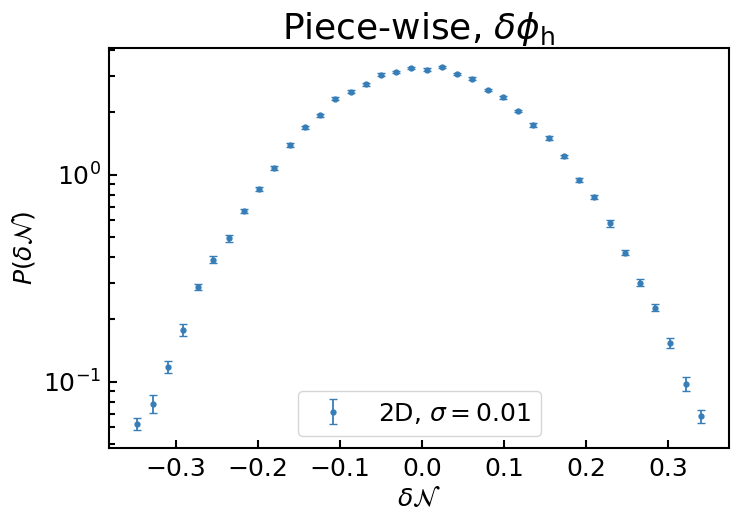

<Figure size 800x520 with 0 Axes>

In [26]:
bin_centres, heights, errors = fpt.numerics.re_processing(Ns, estimator="naive", min_bin_size=100)
# Apply the delta N formula
bin_centres = np.array(bin_centres) - find_cg_time(k_end_scale_later, sigma, N_sim_end_later)

plt.errorbar(bin_centres, heights, yerr=errors, fmt=".", ms=7, label="2D, $\sigma=$"+str(sigma),
            color=color[0])
plt.yscale('log')
plt.legend(fontsize=18)
plt.xlabel(r'$\delta \mathcal{N}$')
plt.ylabel(r'$P(\delta \mathcal{N})$')
plt.title(r"Piece-wise, $\delta \phi_{\mathrm{h}}$")
plt.show()
plt.clf()

Clearly given by a Gaussian!

Now we want to compare this with the Gaussian prediction. To do this we need to find the power spectrum data in and integrate to find the variance.

In [27]:
N_values_for_plot = np.linspace(N_sim_start, N_sim_end, 1000)
N_eval = N_end-5

a_interpolation = CubicSpline(N_values, a_in*np.exp(N_values-N_sim_start))
aH_interpolation = CubicSpline(N_values, hubble_param_values*a_in*np.exp(N_values-N_sim_start))
k_values_integrated_normed = aH_interpolation(N_values_for_plot)/aH_interpolation(N_sim_start)

power_specrum_values = np.zeros(len(N_values_for_plot))
for j in range(len(N_values_for_plot)):
    N_mode_exit = N_values_for_plot[j]
    # Find when this mode left the horizon

    aH_interpolation = CubicSpline(N_values, hubble_param_values*a_in*np.exp(N_values-N_mode_exit))
    a_interpolation = CubicSpline(N_values, a_in*np.exp(N_values-N_mode_exit))

    k = aH_interpolation(N_mode_exit)

    delta_phi = analytical_delta_phi(N_eval, N_end, N_star, A_plus, A_minus, k)
    R = delta_phi/np.sqrt(2*epsilon1_interpolation(N_eval))
    power_specrum_values[j] = power_spectrum_func(k, R)

We also need a function to do the integration.

In [28]:
def analytical_fpt_variance_func(power_spectrum, k_values):
    ln_k_values = np.log(k_values)
    return trapezoid(power_spectrum/k_values, x=k_values)

def gaussian_pdf_generator(std, mean=0):
    def pdf(x):
        expo_term = np.exp(-0.5*((x-mean)/std)**2)
        norm = 1/(std*(2*np.pi)**0.5)
        return norm*expo_term
    return pdf

In [29]:
analytical_fpt_variance = analytical_fpt_variance_func(power_specrum_values, k_values_integrated_normed)
analytical_fpt_std = analytical_fpt_variance**0.5
gaussian_pdf = gaussian_pdf_generator(analytical_fpt_std, mean=0.0)

In [30]:
analytical_fpt_std

0.12190137996950524

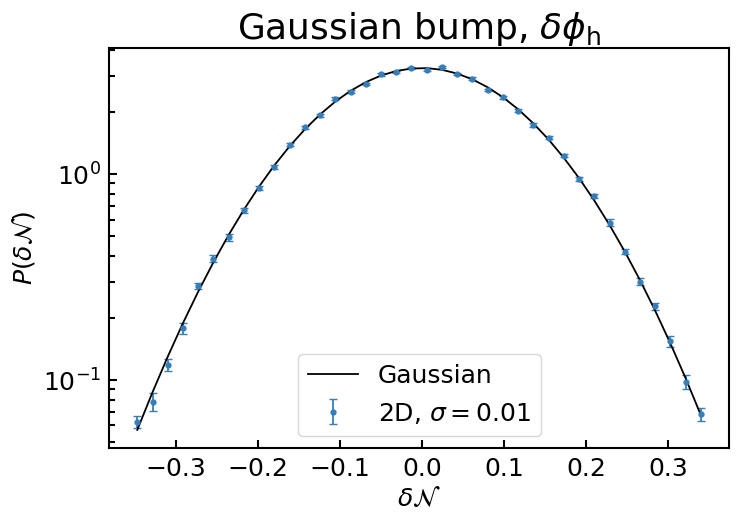

<Figure size 800x520 with 0 Axes>

In [31]:
plt.errorbar(bin_centres, heights, yerr=errors, fmt=".", ms=7, label="2D, $\sigma=$"+str(sigma),
            color=color[0])
plt.plot(bin_centres, gaussian_pdf(bin_centres), color="k",
         label="Gaussian")
plt.yscale('log')
plt.legend(fontsize=18)
plt.xlabel(r'$\delta \mathcal{N}$')
plt.ylabel(r'$P(\delta \mathcal{N})$')
plt.title(r"Gaussian bump, $\delta \phi_{\mathrm{h}}$")
plt.show()
plt.clf()

This is clearly very Gaussian!

## 1D noise
Now let's investigate the effect of using a 2D noise. This is the same as the 2D case but the Cython code is changed.

In [32]:
%%cython -a

import numpy as np

cdef double e = 2.718281828459045
cdef double pi_const = 3.141592653589793
cdef double phi_star = 1.0
cdef double A_plus = 1e-14
cdef double A_minus = 1e-17
cdef double V_0 = 2.871906714642027e-12
cdef double diff_const = 1.5572025557368665e-07
cdef double phi_old


cdef double V_prime_by_V_cython(double phi):
    if phi > phi_star:
        return A_plus/(V_0 + A_plus*(phi - phi_star))
    elif phi <= phi_star:
        return A_minus/(V_0 + A_minus*(phi - phi_star))
    
cdef int end_cond(double phi, double pi, double N, double phi_end):
    if phi<phi_end:
        return 1
    else:
        return 0


cdef list update(double phi, double pi, double A, double N, double dN, double [:] dW, double [:] noise,
                 double bias_amp):
    # Store old phi value to be used in calculating velocity
    phi_old = phi
    # Update field position
    # If noise is zero, no bias is automatically applied
    phi = phi + (pi + bias_amp*noise[0])*dN + noise[0]*dW[0]

    # Update the velocity
    if noise[0]>0:  #Need to include the chance the noise is zero
        pi =\
            pi - (3 - 0.5*pi**2)*(pi + V_prime_by_V_cython(phi_old))*dN +\
             bias_amp*noise[1]*dN + noise[1]*dW[0]

        # Use the standard form for the weight calculation
        A += bias_amp*(0.5*bias_amp*dN + dW[0])
    else:
        pi =\
            pi - (3 - 0.5*pi**2)*(pi + V_prime_by_V_cython(phi_old))*dN
        # No change as no noise is applied.
        A += 0.

    return [phi, pi, A]


#A let's us calculate the bias w=e^-A is the bias, which propagated along with 
#the importance sample path.
#See Eq. (33) of arXiv:nucl-th/9809075v1 for more info
cdef list simulation_diff_general_end(double x_in, double y_in, double t_in,\
                          double t_f, double dt, double bias_amp, double phi_end_in, noise_list, rng):
    cdef double t, sqrt_dt, x, y, z, A
    cdef int i = 0
    cdef int end_cond_value
    cdef int len_rand_nums = 1000
    cdef int reduced_step = 0
    cdef int num_steps = 0
    
    cdef double [:, :] rand_nums
    cdef double [:] dW
    cdef double [:] noise

    t = t_in
    x = x_in
    y = y_in
    sqrt_dt = dt**0.5
    A = 0.0
    rand_nums = rng.normal(0, 1, size=(2, len_rand_nums))
    dW = rand_nums[:, 0]
    noise = noise_list[:, 0]

    while t<t_f:
        # Scale the step varaince to the dt used
        dW[0] = sqrt_dt*rand_nums[0, i]
        dW[1] = sqrt_dt*rand_nums[1, i]
        # Find the noise from the list provided
        noise[0] = noise_list[0, num_steps]
        noise[1] = noise_list[1, num_steps]
        # Define the Wiener step, using the pre-drawn random numbers.
        # Step in x and A simultanioues
        [x, y, A] =\
            update(x, y, A, t, dt, dW, noise, bias_amp)
        t += dt
        i += 1
        num_steps += 1
        # Using 1/0 for True/False
        end_cond_value = end_cond(x, y, t, phi_end_in)
        if end_cond_value == 1:
            break
        elif end_cond_value == -1 and reduced_step == 0:
            dt = dt/100
            sqrt_dt = dt**0.5
            reduced_step = 1
        elif end_cond_value == 0 and reduced_step == 1:
            dt = 100*dt
            sqrt_dt = dt**0.5
            reduced_step = 0
        # If all of the random numbers have been used up, need to update them.
        # This should still be more efficient than drawing a new random number
        # each time.
        if i == len_rand_nums:
            rand_nums = rng.normal(0, 1, size=(2, len_rand_nums))
            i = 0
    return [t, e**(-A)]


cpdef importance_sampling_simulations_2dim_1d_noise(double x_in, double y_in, double t_in, double t_f,
                                           double dt, int num_runs, double bias_amp, double phi_end_in,
                                                noise_list):
    # As this variable is global, I can just redfine it hear
    rng = np.random.default_rng()
    results =\
        [simulation_diff_general_end(x_in, y_in, t_in, t_f, dt, bias_amp, phi_end_in, noise_list, rng)\
         for i in range(num_runs)]
                
    
    ts, ws = [[results[i][j] for i in range(num_runs)] for j in range(2)]
    return ts, ws

In [33]:
def run_func_full_1D(N_exit, N_start, bias_amp, num_runs, noise_matrix, sigma, phi_in_post,
                                phi_deriv_in_post, phi_end, extra_label=None):

    start = timer()
    num_runs_per_core = int(num_runs/mp.cpu_count())

    # Using multiprocessing
    def multi_processing_func(x_in, y_in, t_i, t_f, dt, num_runs, bias_amp, phi_end, noise_matrix, queue_efolds,
                              queue_ws):
        results =\
            importance_sampling_simulations_2dim_1d_noise(x_in, y_in, t_i, t_f, dt, num_runs, bias_amp, phi_end,
                                                      noise_matrix)
        fpt_values = np.array(results[0][:])
        ws = np.array(results[1][:])
        queue_efolds.put(fpt_values)
        queue_ws.put(ws)
    queue_efolds = Queue()
    queue_ws = Queue()
    cores = int(mp.cpu_count()/1)

    print('Number of cores used: '+str(cores))
    processes = [Process(target=multi_processing_func,
                         args=(phi_in_post, phi_deriv_in_post, N_start, 80., dN, num_runs_per_core, bias_amp,
                               phi_end, noise_matrix, queue_efolds, queue_ws))
                 for k in range(cores)]

    for p in processes:
        p.start()

    # More efficient to work with numpy arrays
    fpt_array = np.array([queue_efolds.get() for p in processes])
    ws_array = np.array([queue_ws.get() for p in processes])

    end = timer()
    print(f'The simulations took: {end - start} seconds')

    # Combine into columns into 1
    fpt_values = fpt_array.flatten()
    w_values = ws_array.flatten()

    # Sort in order of increasing Ns
    sort_idx = np.argsort(fpt_values)
    Ns = fpt_values[sort_idx]
    ws = w_values[sort_idx]
    if extra_label != None:
        extra_label = "_sigma_"+str(sigma)+"_A_log_ration_"\
                                           +str(np.log10(A_minus/A_plus))+"scale_exited"+str(round(N_exit, 5))\
                                            + "_1D_" + extra_label
    else:
        extra_label = "_sigma_"+str(sigma)+"_A_log_ration_"\
                                           +str(np.log10(A_minus/A_plus))+"scale_exited"+str(round(N_exit, 5))\
                                            + "_1D"

    fpt.numerics.save_data_to_file(Ns, ws, round(phi_in_post, 5), num_runs, bias_amp,
                      extra_label=extra_label)

As we want to show the peak of the distribution is indepdent of the choice of $\sigma$, we shall use a for loop to load in the required data and run many simulations

In [34]:
sigma_values = np.array([1.0, 0.5, 0.1, 0.01])

num_runs = 10**5

bias_amp = 0.0

for sigma_index in range(len(sigma_values)):
    sigma = sigma_values[sigma_index]

    noise_data = pd.read_csv("piece_wise_linear_noise_curves_Bessel_matched_sigma_"+str(sigma)+"_1D.csv",
                                 index_col=0)

    N_cg_values = np.array(noise_data["N"])

    noise_matrix_array = np.zeros((2, len(N_cg_values)))

    noise_matrix_array[0, :] = np.array(noise_data["phi-phi noise"])
    noise_matrix_array[1, :] = np.array(noise_data["pi-pi noise"])

    # Need to add the zeros such there is enough noise to reach the end of the simulation
    noise_matrix_array_with_zeros = np.zeros((2, len(noise_matrix_array[0,:])+int(4/dN)))

    noise_matrix_array_with_zeros[:, :len(noise_matrix_array[0,:])] = noise_matrix_array
    # Now need to find the correct start position and end value

    aH_interpolation = CubicSpline(N_values, hubble_param_values*a_in*np.exp(N_values-N_sim_start))

    N_start_sigma_exit = find_cg_time(aH_interpolation(N_sim_start), sigma, N_sim_start)
    N_end_sigma_exit = find_cg_time(aH_interpolation(N_sim_end), sigma, N_sim_end)

    # Scales at the start and end
    k_in_scale = aH_interpolation(N_sim_start)
    k_end_scale = aH_interpolation(N_sim_end)

    # This returns an array, so need to convert to a float
    phi_in = float(phi_with_scale_interpolation(k_in_scale/sigma))
    phi_deriv_in = float(phi_diff_with_scale_interpolation(k_in_scale/sigma))

    # end value
    k_end_scale_later = aH_interpolation(N_sim_end_later)
    N_sim_end_later_sigma_exit = find_cg_time(aH_interpolation(N_sim_end_later), sigma, N_sim_end_later)
    phi_end = float(phi_with_scale_interpolation(k_end_scale_later/sigma))

    run_func_full_1D(N_sim_start, N_start_sigma_exit, bias_amp, num_runs, noise_matrix_array_with_zeros, sigma,
                                  phi_in, phi_deriv_in, phi_end, extra_label="bessel")

Number of cores used: 8
The simulations took: 227.7667288449593 seconds
Saved data to file IS_data_x_in_1.0_iterations_100000_bias_0.0_sigma_1.0_A_log_ration_-3.0scale_exited26.05102_1D_bessel.csv
Number of cores used: 8
The simulations took: 227.41354116797447 seconds
Saved data to file IS_data_x_in_0.999_iterations_100000_bias_0.0_sigma_0.5_A_log_ration_-3.0scale_exited26.05102_1D_bessel.csv
Number of cores used: 8
The simulations took: 226.63922665000428 seconds
Saved data to file IS_data_x_in_0.999_iterations_100000_bias_0.0_sigma_0.1_A_log_ration_-3.0scale_exited26.05102_1D_bessel.csv
Number of cores used: 8
The simulations took: 226.84728571900632 seconds
Saved data to file IS_data_x_in_0.999_iterations_100000_bias_0.0_sigma_0.01_A_log_ration_-3.0scale_exited26.05102_1D_bessel.csv


Now let's process this data and compare it against the 2D case and the Gaussian prediction. 

In [35]:
sigma = 0.01

raw_data = pd.read_csv("IS_data_x_in_0.999_iterations_100000_bias_0.0_sigma_0.01_A_log_ration_-3.0"+
                       "scale_exited26.05102_2D_bessel.csv", index_col=0)

# Easier to work with NumPy arrays
Ns = np.array(raw_data['FPTs'])

bin_centres_2D, heights_2D, errors_2D = fpt.numerics.re_processing(Ns, estimator="naive", min_bin_size=100)
# Apply the delta N formula
bin_centres_2D = np.array(bin_centres_2D) - find_cg_time(k_end_scale_later, sigma, N_sim_end_later)

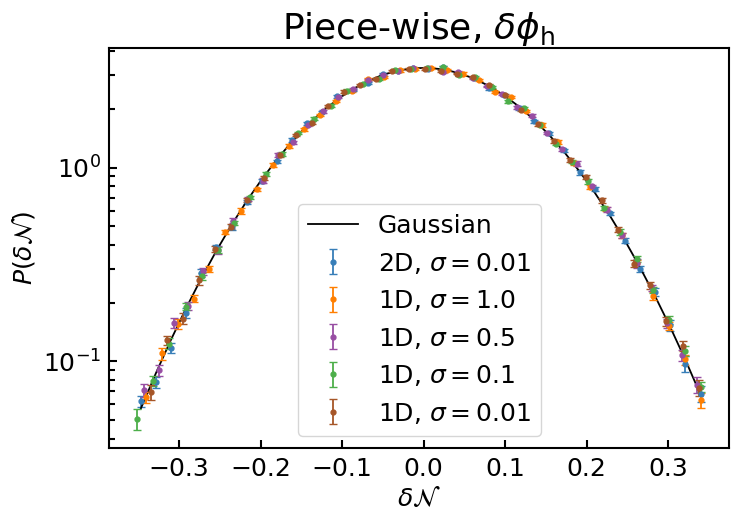

<Figure size 800x520 with 0 Axes>

In [36]:
plt.errorbar(bin_centres_2D, heights_2D, yerr=errors_2D, fmt=".", ms=7, label="2D, $\sigma=$"+str(sigma),
            color=color[0])
plt.plot(bin_centres_2D, gaussian_pdf(bin_centres_2D), color="k",
         label="Gaussian")

# Now let's process and plot the 1D data
for j in range(len(sigma_values)):
    sigma = sigma_values[j]
    if sigma == 1.0:
        raw_data = pd.read_csv("IS_data_x_in_1.0_iterations_100000_bias_0.0_sigma_1.0_A_log_ration_-3.0"+
                               "scale_exited26.05102_1D_bessel.csv", index_col=0)
    else:
        raw_data = pd.read_csv("IS_data_x_in_0.999_iterations_100000_bias_0.0_sigma_"+str(sigma)+
                               "_A_log_ration_-3.0scale_exited26.05102_1D_bessel.csv", index_col=0)

    # Easier to work with NumPy arrays
    Ns = np.array(raw_data['FPTs'])

    bin_centres, heights, errors = fpt.numerics.re_processing(Ns, estimator="naive", min_bin_size=100)
    # Apply the delta N formula
    bin_centres = np.array(bin_centres) - find_cg_time(k_end_scale_later, sigma, N_sim_end_later)

    plt.errorbar(bin_centres, heights, yerr=errors, fmt=".", ms=7, label="1D, $\sigma=$"+str(sigma),
                color=color[j+1])
    
plt.yscale('log')
plt.legend(fontsize=18)
plt.xlabel(r'$\delta \mathcal{N}$')
plt.ylabel(r'$P(\delta \mathcal{N})$')
plt.title(r"Piece-wise, $\delta \phi_{\mathrm{h}}$")
plt.show()
plt.clf()

Clearly all of the data sets are consistent!